Making the csvs for pharos

In [12]:
%pip install sqlalchemy
%pip install numpy
%pip install torch
%pip install scikit-learn
%pip install mysql-connector-python
%pip install matplotlib



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached matplotlib-3.9.2-cp311-cp311-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.0-cp311-cp311-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.54.1-cp311-cp311-macosx_11_0_arm64.whl.metadata (163 kB)
  Using cached kiwisolver-1.4.7-cp311-cp311-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.9.2-cp311-cp311-macosx_11_0_arm64.whl (7.8 MB)
Using cached contourpy-1.3.0-cp311-cp311-macosx_11_0_arm64.whl (250 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using ca

In [5]:
from sqlalchemy import create_engine
import pandas as pd

# Define your database connection parameters
host="localhost"
port=3306
user="root"
password="Afu27959"
database="thesisCurrent"
database2="thesisv6.9"

# Create a SQLAlchemy engine
engine1 = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}/{database}')

engine2 = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}/{database2}')

# Query to get data
query1 = """
SELECT uniprot, tdl FROM protein JOIN target ON protein.ID = target.ID;
"""
df1 = pd.read_sql(query1, engine1) #Current
#print(df1)

query2 = """
SELECT uniprot, tdl FROM protein JOIN target ON protein.ID = target.ID;
"""
df2 = pd.read_sql(query2, engine2) #Older

def compare_versions(df1, df2):
    # Merge dataframes on 'uniprot'
    merged = df1.rename(columns={'tdl': 'TDL_current'}).merge(
        df2.rename(columns={'tdl': 'TDL_v6_9'}),
        on='uniprot',
        how='outer'
    )
    
    # Find proteins that were Tdark in v6.9 and reclassified in v6.11
    reclassified = merged[(merged['TDL_v6_9'] == 'Tdark') & (merged['TDL_current'] != 'Tdark')]
    
    return reclassified

# Compare versions
reclassified_proteins = compare_versions(df1, df2)

# Display results
#print(reclassified_proteins)
#print(f"Number of reclassified proteins: {len(reclassified_proteins)}")
uniprot_list = reclassified_proteins['uniprot'].tolist()

# Format the list for the SQL query
formatted_uniprot_list = "', '".join(uniprot_list)
print(len(uniprot_list))

# Query to get family information from idg_evol table
query_fam = f"""
SELECT DISTINCT uniprot, fam
FROM idg_evol
WHERE uniprot IN ('{formatted_uniprot_list}');
"""

# Fetch the family data from the database
fam_df = pd.read_sql(query_fam, engine1)

# Merge the family data with the reclassified proteins dataframe
reclassified_proteins_with_fam = reclassified_proteins.merge(fam_df, on='uniprot', how='left')

# Display results with the added family column
print(reclassified_proteins_with_fam)
print(f"Number of reclassified proteins: {len(reclassified_proteins_with_fam)}")


1785
     uniprot TDL_current TDL_v6_9  fam
0     A0AV96        Tbio    Tdark  NaN
1     A0AVF1        Tbio    Tdark  NaN
2     A0FGR9        Tbio    Tdark  NaN
3     A0JNW5        Tbio    Tdark  NaN
4     A0PJK1        Tbio    Tdark  NaN
...      ...         ...      ...  ...
1780  Q9Y6I8        Tbio    Tdark  NaN
1781  Q9Y6I9        Tbio    Tdark  NaN
1782  Q9Y6L7       Tchem    Tdark  NaN
1783  Q9Y6Q3        Tbio    Tdark  NaN
1784  Q9Y6V7        Tbio    Tdark  NaN

[1785 rows x 4 columns]
Number of reclassified proteins: 1785


In [6]:
if uniprot_list:
    # Format the list for SQL query
    formatted_uniprot_list = "', '".join(uniprot_list)
    
    # SQL query to get relevant data from the database
    query_data1 = f"""
    SELECT 
        p.uniprot AS uniprot,
        p.seq AS sequence,
        da.smiles AS smiles,
        da.act_value AS affinity
    FROM 
        protein p
    JOIN 
        drug_activity da ON p.id = da.target_id
    WHERE 
        p.uniprot IN ('{formatted_uniprot_list}')
    UNION ALL

    SELECT 
        p.uniprot AS uniprot,
        p.seq AS sequence,
        ca.smiles AS smiles,
        ca.act_value AS affinity
    FROM 
        protein p
    JOIN 
        target t ON p.id = t.id
    JOIN 
        cmpd_activity ca ON t.id = ca.target_id
    WHERE 
        p.uniprot IN ('{formatted_uniprot_list}')
    """

In [7]:
if uniprot_list:
    # Format the list for SQL query
    formatted_uniprot_list = "', '".join(uniprot_list)
    
    # SQL query to get relevant data from the database
    query_data2 = f"""
    SELECT 
        p.seq AS sequence,
        da.smiles AS smiles,
        da.act_value AS affinity
    FROM 
        protein p
    JOIN 
        drug_activity da ON p.id = da.target_id
    WHERE 
        p.seq IS NOT NULL AND p.seq <> '' 
        AND da.smiles IS NOT NULL AND da.smiles <> '' 
        AND da.act_value IS NOT NULL
        AND p.uniprot NOT IN ('{formatted_uniprot_list}')

    UNION ALL

    SELECT 
        p.seq AS sequence,
        ca.smiles AS smiles,
        ca.act_value AS affinity
    FROM 
        protein p
    JOIN 
        target t ON p.id = t.id
    JOIN 
        cmpd_activity ca ON t.id = ca.target_id
    WHERE 
        p.seq IS NOT NULL AND p.seq <> '' 
        AND ca.smiles IS NOT NULL AND ca.smiles <> '' 
        AND ca.act_value IS NOT NULL
        AND p.uniprot NOT IN ('{formatted_uniprot_list}');
    """

In [8]:
import os
from sklearn.model_selection import train_test_split
from stream import drug2emb_encoder, protein2emb_encoder 

affinity_threshold = 7.0 
df_val = pd.read_sql(query_data1, engine1)

df_val['Label'] = (df_val['affinity'] >= affinity_threshold).astype(int)
# Rename columns as needed for MolTrans format
data_df = df_val.rename(columns={
    'smiles': 'SMILES',
    'sequence': 'Target Sequence'
})
# Select relevant columns for the MolTrans format
data_df = data_df[['SMILES', 'Target Sequence', 'Label']]

# Remove rows with NaN or non-string SMILES values
data_df = data_df[data_df['SMILES'].apply(lambda x: isinstance(x, str) and x.strip() != '')]

# Initialize empty lists to store encodings and masks
drug_encodings = []
drug_masks = []
protein_encodings = []
protein_masks = []

# Loop over each row and encode the drug and protein sequences
for _, row in data_df.iterrows():
    # Encode the drug SMILES
    drug_encoding, drug_mask = drug2emb_encoder(row['SMILES'])
    drug_encodings.append(drug_encoding)
    drug_masks.append(drug_mask)
    
    # Encode the protein sequence
    protein_encoding, protein_mask = protein2emb_encoder(row['Target Sequence'])
    protein_encodings.append(protein_encoding)
    protein_masks.append(protein_mask)

# Add encoded data as new columns to the DataFrame
data_df['drug_encoding'] = drug_encodings
data_df['protein_encoding'] = protein_encodings

# Reset the index for each DataFrame so they start from 0
data_df = data_df.reset_index(drop=True)

# Define output paths and save CSV files
output_dir = 'dataset/pharos_full'
os.makedirs(output_dir, exist_ok=True)
data_df.to_csv(f'{output_dir}/val.csv', index=True)


print("validation CSV file created successfully.")

validation CSV file created successfully.


In [10]:
import os
from sklearn.model_selection import train_test_split
from stream import drug2emb_encoder, protein2emb_encoder 

affinity_threshold = 7.0 
# Fetch the data from the database
data_df = pd.read_sql(query_data2, engine1)
# Optional: Rename 'affinity' to 'Label' for compatibility
data_df['Label'] = (data_df['affinity'] >= affinity_threshold).astype(int)
# Rename columns as needed for MolTrans format
data_df = data_df.rename(columns={
    'smiles': 'SMILES',
    'sequence': 'Target Sequence'
})
# Select relevant columns for the MolTrans format
data_df = data_df[['SMILES', 'Target Sequence', 'Label']]

# Remove rows with NaN or non-string SMILES values
data_df = data_df[data_df['SMILES'].apply(lambda x: isinstance(x, str) and x.strip() != '')]

# Initialize empty lists to store encodings and masks
drug_encodings = []
drug_masks = []
protein_encodings = []
protein_masks = []

# Loop over each row and encode the drug and protein sequences
for _, row in data_df.iterrows():
    # Encode the drug SMILES
    drug_encoding, drug_mask = drug2emb_encoder(row['SMILES'])
    drug_encodings.append(drug_encoding)
    drug_masks.append(drug_mask)
    
    # Encode the protein sequence
    protein_encoding, protein_mask = protein2emb_encoder(row['Target Sequence'])
    protein_encodings.append(protein_encoding)
    protein_masks.append(protein_mask)

# Add encoded data as new columns to the DataFrame
data_df['drug_encoding'] = drug_encodings
data_df['protein_encoding'] = protein_encodings


# Split data into train, test, and validation sets
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)

# Reset the index for each DataFrame so they start from 0
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Define output paths and save CSV files
output_dir = 'dataset/pharos_full'
os.makedirs(output_dir, exist_ok=True)

train_df.to_csv(f'{output_dir}/train.csv', index=True)
test_df.to_csv(f'{output_dir}/test.csv', index=True)


print("Train and test CSV files created successfully.")

Train and test CSV files created successfully.


In [21]:

# Find rows where SMILES is NaN or not a valid string
nan_rows = data_df[data_df['SMILES'].isna() | data_df['SMILES'].apply(lambda x: not isinstance(x, str) or x.strip() == '')]

# Print these rows
print("Rows with NaN or invalid SMILES values:")
print(nan_rows)

Rows with NaN or invalid SMILES values:
   SMILES                                    Target Sequence  Label  \
18         MGLARALRRLSGALDSGDSRAGDEEEAGPGLCRNGWAPAPVQSPVG...      0   
19         MGLARALRRLSGALDSGDSRAGDEEEAGPGLCRNGWAPAPVQSPVG...      0   
20         MGLARALRRLSGALDSGDSRAGDEEEAGPGLCRNGWAPAPVQSPVG...      1   

                                        drug_encoding  \
18  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
19  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
20  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                     protein_encoding  
18  [958, 48, 464, 3838, 447, 6718, 11, 584, 342, ...  
19  [958, 48, 464, 3838, 447, 6718, 11, 584, 342, ...  
20  [958, 48, 464, 3838, 447, 6718, 11, 584, 342, ...  


In [5]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch import nn 
import copy

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, roc_curve, confusion_matrix, precision_score, recall_score, auc
from sklearn.model_selection import KFold
torch.manual_seed(1)    # reproducible torch:2 np:3
np.random.seed(1)

from config import BIN_config_DBPE
from models import BIN_Interaction_Flat
from stream import BIN_Data_Encoder
import torch
print(torch.cuda.is_available())

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

False


In [17]:
def test(data_generator, model):
    y_pred = []
    y_label = []
    model.eval()
    loss_accumulate = 0.0
    count = 0.0
    for i, (d, p, d_mask, p_mask, label) in enumerate(data_generator):
        score = model(d.long().cuda(), p.long().cuda(), d_mask.long().cuda(), p_mask.long().cuda())
        
        m = torch.nn.Sigmoid()
        logits = torch.squeeze(m(score))
        loss_fct = torch.nn.BCELoss()            
        
        label = Variable(torch.from_numpy(np.array(label)).float()).cuda()

        loss = loss_fct(logits, label)
        
        loss_accumulate += loss
        count += 1
        
        logits = logits.detach().cpu().numpy()
        
        label_ids = label.to('cpu').numpy()
        y_label = y_label + label_ids.flatten().tolist()
        y_pred = y_pred + logits.flatten().tolist()
        
    loss = loss_accumulate/count
    
    fpr, tpr, thresholds = roc_curve(y_label, y_pred)

    precision = tpr / (tpr + fpr)

    f1 = 2 * precision * tpr / (tpr + precision + 0.00001)

    thred_optim = thresholds[5:][np.argmax(f1[5:])]

    print("optimal threshold: " + str(thred_optim))

    y_pred_s = [1 if i else 0 for i in (y_pred >= thred_optim)]

    auc_k = auc(fpr, tpr)
    print("AUROC:" + str(auc_k))
    print("AUPRC: "+ str(average_precision_score(y_label, y_pred)))

    cm1 = confusion_matrix(y_label, y_pred_s)
    print('Confusion Matrix : \n', cm1)
    print('Recall : ', recall_score(y_label, y_pred_s))
    print('Precision : ', precision_score(y_label, y_pred_s))

    total1=sum(sum(cm1))
    #####from confusion matrix calculate accuracy
    accuracy1=(cm1[0,0]+cm1[1,1])/total1
    print ('Accuracy : ', accuracy1)

    sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    print('Sensitivity : ', sensitivity1 )

    specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    print('Specificity : ', specificity1)

    outputs = np.asarray([1 if i else 0 for i in (np.asarray(y_pred) >= 0.5)])
    return roc_auc_score(y_label, y_pred), average_precision_score(y_label, y_pred), f1_score(y_label, outputs), y_pred, loss.item()


def main(fold_n, lr):
    config = BIN_config_DBPE()
    
    lr = lr
    BATCH_SIZE = config['batch_size']
    train_epoch = 100
    
    loss_history = []
    
    model = BIN_Interaction_Flat(**config)
    
    model = model.cuda()

    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model, dim = 0)
            
    opt = torch.optim.Adam(model.parameters(), lr = lr)
    #opt = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9)
    
    print('--- Data Preparation ---')
    
    params = {'batch_size': BATCH_SIZE,
              'shuffle': True,
              'num_workers': 6, 
              'drop_last': True}

    dataFolder = './dataset/pharos'
    df_train = pd.read_csv(dataFolder + '/train.csv')
    df_val = pd.read_csv(dataFolder + '/val.csv')
    df_test = pd.read_csv(dataFolder + '/test.csv')
    
    training_set = BIN_Data_Encoder(df_train.index.values, df_train.Label.values, df_train)
    training_generator = data.DataLoader(training_set, **params)

    validation_set = BIN_Data_Encoder(df_val.index.values, df_val.Label.values, df_val)
    validation_generator = data.DataLoader(validation_set, **params)
    
    testing_set = BIN_Data_Encoder(df_test.index.values, df_test.Label.values, df_test)
    testing_generator = data.DataLoader(testing_set, **params)
    
    # early stopping
    max_auc = 0
    model_max = copy.deepcopy(model)
    
    print('--- Go for Training ---')
    torch.backends.cudnn.benchmark = True
    for epo in range(train_epoch):
        model.train()
        for i, (d, p, d_mask, p_mask, label) in enumerate(training_generator):
            score = model(d.long().cuda(), p.long().cuda(), d_mask.long().cuda(), p_mask.long().cuda())

            label = Variable(torch.from_numpy(np.array(label)).float()).cuda()
            
            loss_fct = torch.nn.BCELoss()
            m = torch.nn.Sigmoid()
            n = torch.squeeze(m(score))
            
            loss = loss_fct(n, label)
            loss_history.append(loss)
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            if (i % 100 == 0):
                print('Training at Epoch ' + str(epo + 1) + ' iteration ' + str(i) + ' with loss ' + str(loss.cpu().detach().numpy()))
            
        # every epoch test
        with torch.set_grad_enabled(False):
            auc, auprc, f1, logits, loss = test(validation_generator, model)
            if auc > max_auc:
                model_max = copy.deepcopy(model)
                max_auc = auc
            
            print('Validation at Epoch '+ str(epo + 1) + ' , AUROC: '+ str(auc) + ' , AUPRC: ' + str(auprc) + ' , F1: '+str(f1))
    
    print('--- Go for Testing ---')
    try:
        with torch.set_grad_enabled(False):
            auc, auprc, f1, logits, loss = test(testing_generator, model_max)
            print('Testing AUROC: ' + str(auc) + ' , AUPRC: ' + str(auprc) + ' , F1: '+str(f1) + ' , Test loss: '+str(loss))
    except:
        print('testing failed')
    return model_max, loss_history

In [18]:
# fold 1
#biosnap interaction times 1e-6, flat, batch size 64, len 205, channel 3, epoch 50
s = time()
model_max, loss_history = main(1, 5e-6)
e = time()
print(e-s)
lh = list(filter(lambda x: x < 1, loss_history))
plt.plot(lh)

AssertionError: Torch not compiled with CUDA enabled

In [6]:
# Initialize your configuration
config = BIN_config_DBPE()  # This should create a configuration dictionary for the model

# Create an instance of the model
model = BIN_Interaction_Flat(**config)

# Load the state dictionary from the saved model, ensuring it's mapped to CPU
model.load_state_dict(torch.load("model_max.pth", map_location=torch.device('cpu')))  # Use the appropriate file path

# Set the model to evaluation mode
model.eval()


/var/folders/0v/h_hg_1mj17d5ssrjq1z2m6x80000gp/T/ipykernel_70178/1647028041.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_max.p

BIN_Interaction_Flat(
  (demb): Embeddings(
    (word_embeddings): Embedding(23532, 384)
    (position_embeddings): Embedding(50, 384)
    (LayerNorm): LayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (pemb): Embeddings(
    (word_embeddings): Embedding(16693, 384)
    (position_embeddings): Embedding(545, 384)
    (LayerNorm): LayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (d_encoder): Encoder_MultipleLayers(
    (layer): ModuleList(
      (0-1): 2 x Encoder(
        (attention): Attention(
          (self): SelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): SelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm()
            

In [ ]:
import pandas as pd
from stream import BIN_Data_Encoder

# Load the validation data from CSV
data_path = 'dataset/pharos/val.csv'  # Update with your actual path
df_val = pd.read_csv(data_path)
validation_set = BIN_Data_Encoder(df_val.index.values, df_val.Label.values, df_val)
from torch.utils import data

# Define DataLoader parameters
params = {
    "batch_size": 32,  # Adjust based on your memory constraints
    "shuffle": False,  # No need to shuffle for validation
    "num_workers": 4,  # Adjust based on your system's capabilities
    "drop_last": False,
}

validation_generator = data.DataLoader(validation_set, **params)

import torch

# Assuming you have already loaded your model
model.eval()  # Set the model to evaluation mode

predictions = []  # To store all predictions

with torch.no_grad():  # Disable gradient calculation
    for d, p, d_mask, p_mask, _ in validation_generator:  # Assume the last value is the label and can be ignored
        # Move input data to CPU if required
        d, p, d_mask, p_mask = d.to(torch.device('cpu')), p.to(torch.device('cpu')), d_mask.to(torch.device('cpu')), p_mask.to(torch.device('cpu'))

        # Get model predictions
        output = model(d, p, d_mask, p_mask)
        
        # Apply sigmoid to get probabilities
        probabilities = torch.sigmoid(output).cpu().numpy()  # Move to CPU and convert to numpy array
        predictions.extend(probabilities.flatten().tolist())  # Append predictions to the list

# Now `predictions` contains the model's predicted probabilities


ZeroDivisionError: division by zero

ROC AUC Score: 0.850
Precision-Recall AUC Score: 0.966
F1 Score: 0.841
Precision: 0.957
Recall: 0.750

Confusion Matrix:
[[12  2]
 [15 45]]


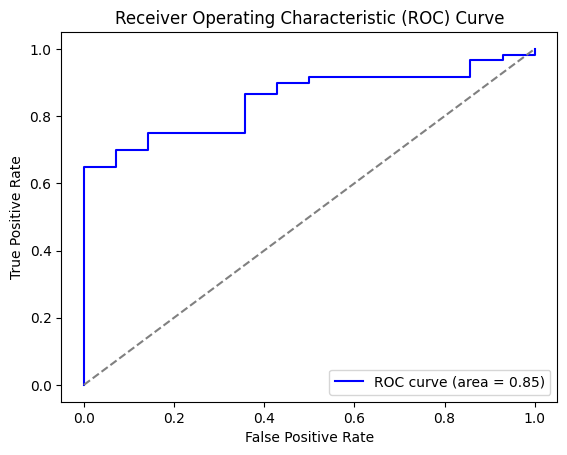

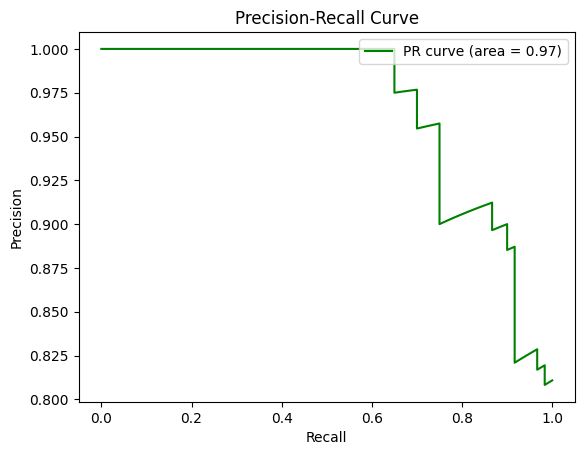

In [8]:
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, roc_curve, precision_score, recall_score, auc, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt

# Paths to files
predictions_path = "predictions.csv"  # Path to your predictions CSV
labels_path = "dataset/pharos/val.csv"  # Path to val.csv containing true labels

# Load data
predictions_df = pd.read_csv(predictions_path)
labels_df = pd.read_csv(labels_path)

# Ensure the column names are correct
if "Prediction" not in predictions_df.columns:
    raise ValueError("The predictions CSV must contain a 'Prediction' column.")
if "Label" not in labels_df.columns:
    raise ValueError("The labels CSV must contain a 'Labels' column.")

# Extract true labels and predicted probabilities
y_true = labels_df["Label"].values  # True labels (0 or 1)
y_pred_prob = predictions_df["Prediction"].values  # Predicted probabilities (between 0 and 1)

# Convert predictions to binary with a threshold of 0.5
threshold = 0.5
y_pred_binary = (y_pred_prob >= threshold).astype(int)

# Calculate evaluation metrics
roc_auc = roc_auc_score(y_true, y_pred_prob)
pr_auc = average_precision_score(y_true, y_pred_prob)
f1 = f1_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
conf_matrix = confusion_matrix(y_true, y_pred_binary)

# Print the metrics
print(f"ROC AUC Score: {roc_auc:.3f}")
print(f"Precision-Recall AUC Score: {pr_auc:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_pred_prob)
plt.figure()
plt.plot(recall_vals, precision_vals, color='green', label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


ROC AUC Score: 0.714
Precision-Recall AUC Score: 0.892
F1 Score: 0.488
Precision: 0.909
Recall: 0.333

Confusion Matrix:
[[12  2]
 [40 20]]


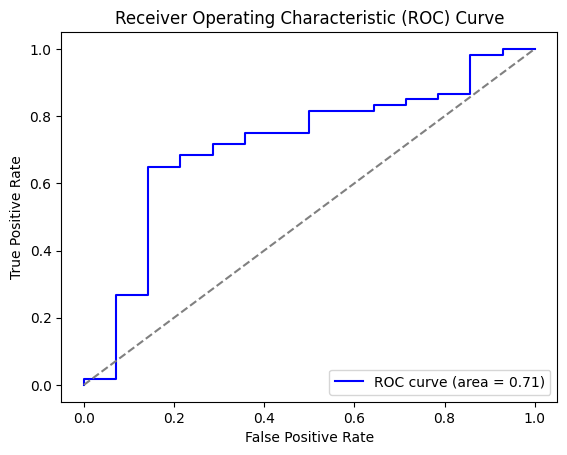

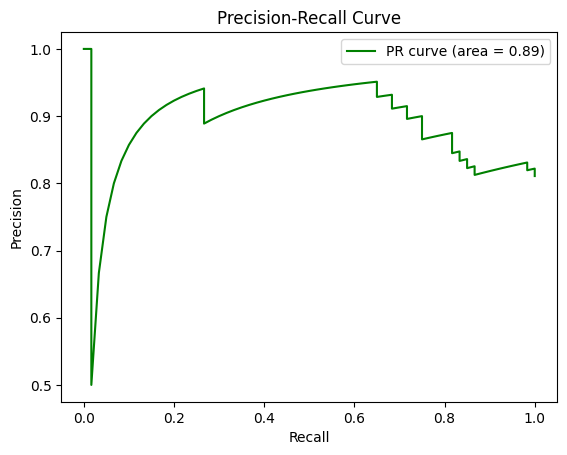

In [10]:
import pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, roc_curve, precision_score, recall_score, auc, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt

# Paths to files
predictions_path = "predictions5.csv"  # Path to your predictions CSV
labels_path = "dataset/pharos/val.csv"  # Path to val.csv containing true labels

# Load data
predictions_df = pd.read_csv(predictions_path)
labels_df = pd.read_csv(labels_path)

# Ensure the column names are correct
if "Prediction" not in predictions_df.columns:
    raise ValueError("The predictions CSV must contain a 'Prediction' column.")
if "Label" not in labels_df.columns:
    raise ValueError("The labels CSV must contain a 'Labels' column.")

# Extract true labels and predicted probabilities
y_true = labels_df["Label"].values  # True labels (0 or 1)
y_pred_prob = predictions_df["Prediction"].values  # Predicted probabilities (between 0 and 1)

# Convert predictions to binary with a threshold of 0.5
threshold = 0.5
y_pred_binary = (y_pred_prob >= threshold).astype(int)

# Calculate evaluation metrics
roc_auc = roc_auc_score(y_true, y_pred_prob)
pr_auc = average_precision_score(y_true, y_pred_prob)
f1 = f1_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
conf_matrix = confusion_matrix(y_true, y_pred_binary)

# Print the metrics
print(f"ROC AUC Score: {roc_auc:.3f}")
print(f"Precision-Recall AUC Score: {pr_auc:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_pred_prob)
plt.figure()
plt.plot(recall_vals, precision_vals, color='green', label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

